**Thống kê máy tính và Ứng dụng**  
Học kì II, 2020 - 2021

<hr>

<br>
<center><b><font size="10">ĐỒ ÁN 2</font></b></center>
<br>

<center>
    <b>Nhóm thực hiện:</b>
    <br> Trần Minh Trí - 1712834
    <br> Nguyễn Nhật Trường - 1712852
    <br> Nguyễn Duy Khải - 1712513
    <br> Võ Nhật Thịnh - 1712796
    <br> Nguyễn Phước Sang - 1712719
</center>

<hr>

#### Các thư viện hỗ trợ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from tensorflow.keras.datasets.mnist import load_data

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import pickle
import os.path

%matplotlib inline
import matplotlib.pyplot as plt

from progressbar import Percentage, ProgressBar,Bar,ETA
import time

# I. Dữ liệu

Dữ liệu MNIST thu thập bằng tensorflow (tensorflow.keras.datasets.mnist)

## 1. Thu thập dữ liệu

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [3]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [4]:
data = pd.DataFrame(x_train, columns = ['pixel_{0}'.format(i+1) for i in range(x_train.shape[1])])
data.insert(0, 'label', y_train)
data.head()

,label,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,pixel_784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Hiển thị một số hình ảnh và nhãn

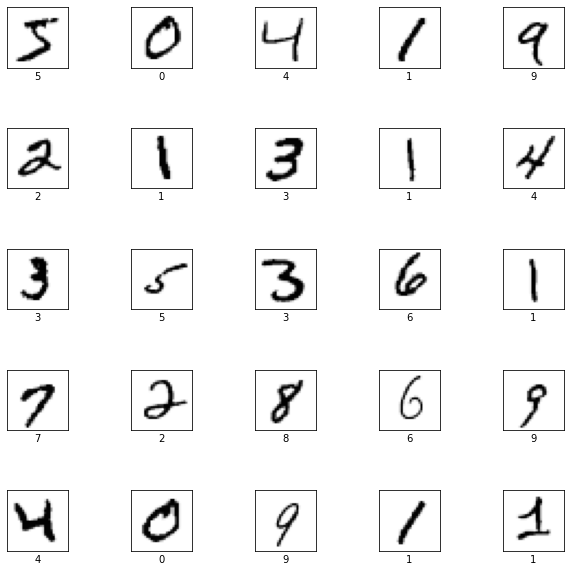

In [5]:
def plot_img(data, numbers_image):
    cells = math.ceil(math.sqrt(numbers_image))

    plt.figure(figsize=(10, 10))

    for index in range(numbers_image):
        value = data[index : index + 1].values
        digit_pixels = value[0][1:]

        image_size = int(math.sqrt(digit_pixels.shape[0]))

        matrix = digit_pixels.reshape((image_size, image_size))

        plt.subplot(cells, cells, index + 1)
        plt.imshow(matrix, cmap='Greys')
        plt.xlabel(value[0][0])
        plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplots_adjust(hspace=1, wspace=1)
    plt.show()
    
plot_img(data, 25)

# II. Tiền xử lí

In [6]:
X = data.values[:, 1:]
Y = data.values[:, [0]]

## 1. Tách tập dữ liệu huấn luyện

Dữ liệu huấn luyện được tách 

In [7]:
kf = KFold(n_splits=5)

In [8]:
X_train, X_val = [], []
Y_train, Y_val = [], []

for train_index, val_index in kf.split(X):
    X_train.append(X[train_index])
    X_val.append(X[val_index])
    Y_train.append(Y[train_index])
    Y_val.append(Y[val_index])

In [9]:
len(X_train), len(X_val)

(5, 5)

In [10]:
X_train[0].shape, X_val[0].shape

((48000, 784), (12000, 784))

## 2. Xử lí dữ liệu

### 2.1. Loại bỏ các pixel hằng

Loại bỏ các pixel luôn mang giá trị 0 (luôn trắng) hoặc 255 (luôn đen) không có ý nghĩa trong việc phân loại.

In [11]:
# Ai tối ưu đc thì sửa nha vì mình chỉ biết đổi qua pandas thoy
def drop_const_pixel(train, to_drop = None):
    df = pd.DataFrame(train, columns = ['pixel_{0}'.format(i+1) for i in range(train.shape[1])])
    if to_drop is None:
        to_drop = []
        for c in df.columns:
            if max(df[c]) == 0 or min(df[c]) == 255:
                to_drop.append(c)
            
    df.drop(to_drop, axis = 1, inplace = True)
    
    return df.values, to_drop

### 2.2. Chuẩn hoá

Chuẩn hóa bằng StandardScaler

In [12]:
def normalize(train, val):
    scalers = []
    drop_cols = []
    scaled_X_train, scaled_X_val = [], []
    
    pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                       maxval=100).start()

    for i in pbar(range(len(train))):
        train_i, drop_col = drop_const_pixel(train[i])
        if val is not None:
            val_i, _ = drop_const_pixel(val[i], drop_col)
        s = StandardScaler().fit(train_i)

        scaled_X_train.append(s.transform(train_i))
        if val is not None:
            scaled_X_val.append(s.transform(val_i))

        scalers.append(s)
        drop_cols.append(drop_col)
        
    return scaled_X_train, scaled_X_val, scalers, drop_cols

Chuẩn hóa bằng cách chuyển mọi pixel thàng trắng hoặc đen (0-1)

In [13]:
# Ai tối ưu đc thì sửa nha vì mình chỉ biết đổi qua pandas thoy
def intensity_rescaling(train):
    df = pd.DataFrame(train, columns = ['pixel_{0}'.format(i+1) for i in range(train.shape[1])])
    
    df[df < 128] = 0
    df[df >= 128] = 1
    
    return df.values

In [14]:
def rescaling(train, val):
    scaled_X_train, scaled_X_val = [], []
    drop_cols = []
    
    pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                       maxval=100).start()
    
    for i in pbar(range(len(train))):
        train_i, drop_col = drop_const_pixel(train[i])
        if val is not None:
            val_i, _ = drop_const_pixel(val[i], drop_col)
        
        scaled_X_train.append(intensity_rescaling(train_i))
        if val is not None:
            scaled_X_val.append(intensity_rescaling(val_i))
        
        drop_cols.append(drop_col)
        
    return scaled_X_train, scaled_X_val, drop_cols

In [15]:
norm_X_train, norm_X_val, scalers, norm_drop_col = normalize(X_train, X_val)
rescaled_X_train, rescaled_X_val, rescale_drop_col = rescaling(X_train, X_val)

[==========================================================] 100% Time: 0:00:41
[==========================================================] 100% Time: 0:00:41


# III. Hồi quy Logistic

## 1. Huấn luyện và tìm mô hình tốt nhất

In [16]:
def run_test(train_X, train_Y, val_X, val_Y, C, solver):
    model = linear_model.LogisticRegression(C=C, solver=solver, max_iter=200)
    
    train_score, val_score = [], []
    for i in range(len(train_X)):
        t_X, t_Y = train_X[i], train_Y[i]
        v_X, v_Y = val_X[i], val_Y[i]
        
        model.fit(t_X, t_Y.reshape(t_Y.shape[0],))
        
        train_score.append(model.score(t_X, t_Y.reshape(t_Y.shape[0],)))
        val_score.append(model.score(v_X, v_Y.reshape(v_Y.shape[0],)))
    
    return model, np.mean(train_score), np.mean(val_score)

In [17]:
def run_multi_test(train_X, train_Y, val_X, val_Y, Cs, solvers, saved_result_to):
    train_score, test_score = [], []
    config = []
    
    if not os.path.isfile(saved_result_to):
        with open(saved_result_to, "w") as file:
            file.write("Config, Train_Score, Val_Score\n")
            file.close()
            
    _ts = time.time()
    
    for s in solvers:
        print(' Sovlers:', s)
        for c in Cs:
            es = time.time()
            print('   + C:', c)
            model, ts, vs = run_test(train_X, train_Y, val_X, val_Y, c, s)
            
            with open(saved_result_to, "a") as file:
                file.write("({0}; {1}), {2}, {3}\n".format(s, c, ts, vs))
                file.close()
            
            config.append((s, c))
            train_score.append(ts)
            test_score.append(vs)
            
            print('     ', ts, vs)
            
            print('     Elapsed: ', np.round(time.time() - es, 2), 's, total: ', \
                  np.round((time.time() - _ts) / 60, 2), 'm', sep='')
            
            
    result = pd.DataFrame(list(zip(config, train_score, test_score)), \
                  columns =['Config', 'Train Score', 'Test Score'])
    
    return result

In [18]:
Cs = [10, 5, 3, 2, 1, 0.1, 0.01, 0.001]
solvers = ['lbfgs', 'sag', 'saga']

In [19]:
#norm_result = run_multi_test(norm_X_train, Y_train, norm_X_val, Y_val, Cs, solvers, 'Norm_result.csv')
norm_result = pd.read_csv('Norm_result.csv')
norm_result

,Config,Train_Score,Val_Score
0,('lbfgs'; 1),0.947258,0.911700
1,('lbfgs'; 0.1),0.944625,0.918200
2,('lbfgs'; 0.01),0.936917,0.921950
3,('lbfgs'; 0.001),0.921925,0.914850
4,('sag'; 1),0.935092,0.919933
5,('sag'; 0.1),0.934833,0.919850
6,('sag'; 0.01),0.932954,0.919617
7,('sag'; 0.001),0.920671,0.913500
8,('saga'; 1),0.930958,0.918933
9,('saga'; 0.1),0.930792,0.918850


In [20]:
norm_result.loc[norm_result[' Val_Score'].argmax()] 

Config          ('lbfgs'; 0.01)
 Train_Score           0.936917
 Val_Score              0.92195
Name: 2, dtype: object

In [21]:
#rescaled_result = run_multi_test(rescaled_X_train, Y_train, rescaled_X_val, Y_val, Cs, solvers, 'Rescaled_result.csv')
rescaled_result = pd.read_csv('Rescaled_result.csv')
rescaled_result

,Config,Train_Score,Val_Score
0,('lbfgs'; 1),0.936592,0.910050
1,('lbfgs'; 0.1),0.929446,0.912517
2,('lbfgs'; 0.01),0.915125,0.907017
3,('lbfgs'; 0.001),0.889450,0.886083
4,('sag'; 1),0.937250,0.910350
5,('sag'; 0.1),0.929417,0.912650
6,('sag'; 0.01),0.915125,0.907017
7,('sag'; 0.001),0.889458,0.886083
8,('saga'; 1),0.937037,0.910317
9,('saga'; 0.1),0.929408,0.912650


In [22]:
rescaled_result.loc[rescaled_result[' Val_Score'].argmax()] 

Config          ('sag'; 0.1)
 Train_Score        0.929417
 Val_Score           0.91265
Name: 5, dtype: object

## 2. Đánh giá mô hình

In [23]:
norm_X, _, scaler, drop_col = normalize([X], val=None)
norm_X = norm_X[0]
norm_scaler = scaler[0]
norm_drop_col = drop_col[0]

norm_model_path = 'norm.pkl'
if os.path.isfile(norm_model_path):
    norm_model = pickle.load(open(norm_model_path, 'rb'))
else:
    norm_model = linear_model.LogisticRegression(C=0.01, solver='lbfgs', max_iter=200)

    norm_model.fit(norm_X, Y.reshape(Y.shape[0], ))
    
    pickle.dump(norm_model, open(norm_model_path, 'wb+'))
    
norm_model

[==========================================================] 100% Time: 0:00:09


LogisticRegression(C=0.01, max_iter=200)

In [24]:
rescaled_X, _, drop_col = rescaling([X], val=None)
rescaled_X = rescaled_X[0]
rescaled_drop_col = drop_col[0]

rescaled_model_path = 'norm.pkl'
if os.path.isfile(rescaled_model_path):
    rescaled_model = pickle.load(open(rescaled_model_path, 'rb'))
else:
    rescaled_model = linear_model.LogisticRegression(C=0.1, solver='sag', max_iter=200)

    rescaled_model.fit(rescaled_X, Y.reshape(Y.shape[0], ))
    
    pickle.dump(norm_model, open(rescaled_model_path, 'wb+'))

rescaled_model

[==========================================================] 100% Time: 0:00:09


LogisticRegression(C=0.01, max_iter=200)

In [25]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            if cm[i, j] == 0:
                plt.text(j, i, 0,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


def model_validation(model, X_train, X_test, Y_train, Y_test):
    #in_sample_prediction = model.predict(X_train)
    #mse = mean_squared_error(Y_train, in_sample_prediction)
    
    #print("In-sample match: ", model.score(X_train, Y_train)*100, "%")
    
    #plot_confusion_matrix(confusion_matrix(in_sample_prediction,  Y_train), np.unique(Y), title='Confusion matrix Normalized', cmap=None)
    #plot_confusion_matrix(confusion_matrix(in_sample_prediction,  Y_train), np.unique(Y), title='Confusion matrix', cmap=None, normalize=False)
    
    print('---------------------------------------')
    prediction = model.predict(X_test)
    mse_out =  mean_squared_error(Y_test, prediction)
    print("Out-sample match: ", model.score(X_test, Y_test)*100, "%")
    # plot_confusion_matrix(confusion_matrix(prediction,  Y_test), np.unique(Y), title='Confusion matrix Normalized', cmap=None)
    plot_confusion_matrix(confusion_matrix(prediction,  Y_test), np.unique(Y), title='Confusion matrix', cmap=None, normalize=False)

---------------------------------------
Out-sample match:  92.63 %


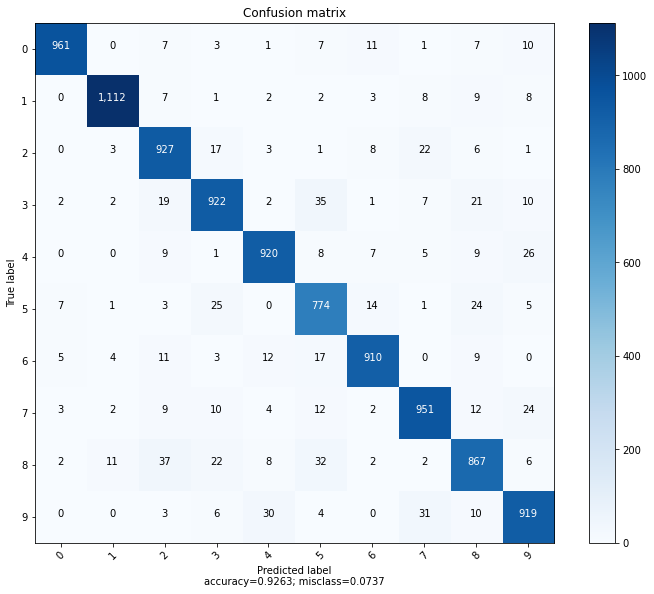

In [26]:
_test, _ = drop_const_pixel(x_test, norm_drop_col)

norm_x_test = norm_scaler.transform(_test)

model_validation(norm_model, norm_X, norm_x_test, Y.reshape(Y.shape[0], ), y_test)

---------------------------------------
Out-sample match:  30.31 %


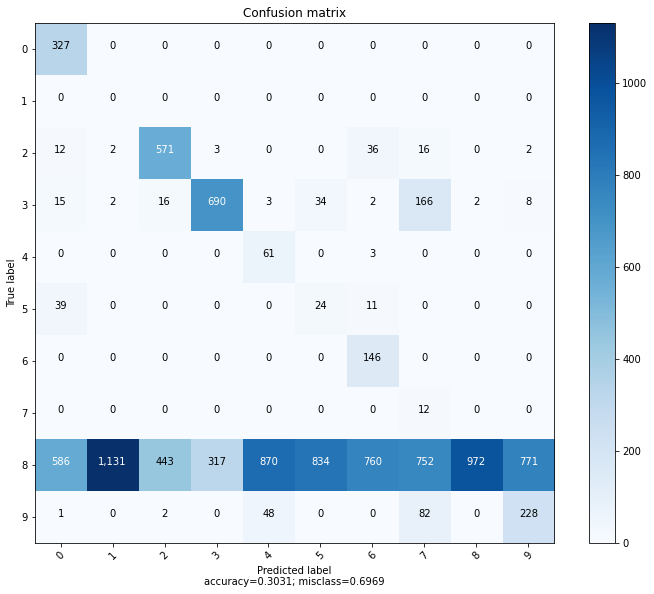

In [27]:
_test, _ = drop_const_pixel(x_test, rescaled_drop_col)

rescaled_x_test = intensity_rescaling(_test)

model_validation(rescaled_model, rescaled_X, rescaled_x_test, Y.reshape(Y.shape[0], ), y_test)

## 3. Áp dụng Ensemble Learning để nâng cao kết quả dự đoán

In [28]:
norm_result.sort_values(by=[' Val_Score'], ascending=False).head()

,Config,Train_Score,Val_Score
2,('lbfgs'; 0.01),0.936917,0.921950
18,(sag; 5),0.935117,0.920017
17,(sag; 3),0.935108,0.919967
19,(sag; 10),0.935125,0.919950
4,('sag'; 1),0.935092,0.919933


In [29]:
rescaled_result.sort_values(by=[' Val_Score'], ascending=False).head()

,Config,Train_Score,Val_Score
9,('saga'; 0.1),0.929408,0.912650
5,('sag'; 0.1),0.929417,0.912650
1,('lbfgs'; 0.1),0.929446,0.912517
4,('sag'; 1),0.937250,0.910350
8,('saga'; 1),0.937037,0.910317


In [30]:
rescaled_models_path = 'rescaled_models.pkl'
if os.path.isfile(rescaled_models_path):
    rescaled_model_list = pickle.load(open(rescaled_models_path, 'rb'))
else:
    rescaled_model_list = [rescaled_model]
    rescaled_model_list.append(linear_model.LogisticRegression(C=0.1, solver='saga', max_iter=200))
    rescaled_model_list.append(linear_model.LogisticRegression(C=0.1, solver='lbfgs', max_iter=200))

    rescaled_model_list[1].fit(rescaled_X, Y.reshape(Y.shape[0], ))
    rescaled_model_list[2].fit(rescaled_X, Y.reshape(Y.shape[0], ))
    rescaled_model_list.append(linear_model.LogisticRegression(C=1, solver='saga', max_iter=200))
    rescaled_model_list.append(linear_model.LogisticRegression(C=1, solver='sag', max_iter=200))

    rescaled_model_list[3].fit(rescaled_X, Y.reshape(Y.shape[0], ))
    rescaled_model_list[4].fit(rescaled_X, Y.reshape(Y.shape[0], ))

    pickle.dump(rescaled_model_list, open(rescaled_models_path, 'wb+'))
    
norm_models_path = 'norm_models.pkl'
if os.path.isfile(norm_models_path):
    norm_model_list = pickle.load(open(norm_models_path, 'rb'))
else:
    norm_model_list = [norm_model]
    norm_model_list.append(linear_model.LogisticRegression(C=5, solver='sag', max_iter=200))
    norm_model_list.append(linear_model.LogisticRegression(C=3, solver='sag', max_iter=200))

    norm_model_list[1].fit(norm_X, Y.reshape(Y.shape[0], ))
    norm_model_list[2].fit(norm_X, Y.reshape(Y.shape[0], ))
    
    norm_model_list.append(linear_model.LogisticRegression(C=10, solver='sag', max_iter=200))
    norm_model_list.append(linear_model.LogisticRegression(C=1, solver='sag', max_iter=200))

    norm_model_list[3].fit(norm_X, Y.reshape(Y.shape[0], ))
    norm_model_list[4].fit(norm_X, Y.reshape(Y.shape[0], ))
    
    pickle.dump(norm_model_list, open(norm_models_path, 'wb+'))

In [31]:
class MNIST_Ensemble_Linear_Log_Reg:
    def __init__(self, ensemblers, weight, norm_scaler, norm_drop_col, rescaled_drop_col):
        self.ensemblers = ensemblers
        assert len(ensemblers) == len(weight)
        self.weight = weight
        self.norm_scaler = norm_scaler
        self.norm_drop_col = norm_drop_col
        self.rescaled_drop_col = rescaled_drop_col
        
    def info(self):
        for i in range(len(self.ensemblers)):
            print(self.ensemblers[i][0], self.ensemblers[i][1], self.weight[i])
        print(self.norm_scaler)
        #print(self.norm_drop_col)
        #print(self.rescaled_drop_col)
        
    def predict(self, X):
        _s_test, _ = drop_const_pixel(X, self.rescaled_drop_col)
        rescaled_x = intensity_rescaling(_s_test)
        
        _n_test, _ = drop_const_pixel(X, self.norm_drop_col)
        norm_x = norm_scaler.transform(_n_test)
        
        predictions = []
        for model, _type in self.ensemblers:
            if _type == 0:
                predictions.append(model.predict(norm_x))
            elif _type == 1:
                predictions.append(model.predict(rescaled_x))
            else:
                raise ValueError()
        
        y = []
        for i in range(len(predictions[0])):
            _d = dict.fromkeys(range(10),0)
            
            for j in range(len(self.ensemblers)):
                _d[predictions[j][i]] += self.weight[j]
                
            y.append(max(_d, key=_d.get))
        
        return np.array(y).reshape(len(y),)
    
    def score(self, X, Y):
        y = self.predict(X)
        
        return np.mean(y == Y)

In [32]:
[ e for e in [(m, 0) for m in norm_model_list] +
                                                [(m, 1) for m in rescaled_model_list] ]

[(LogisticRegression(C=0.01, max_iter=200), 0),
 (LogisticRegression(C=5, max_iter=200, solver='sag'), 0),
 (LogisticRegression(C=3, max_iter=200, solver='sag'), 0),
 (LogisticRegression(C=10, max_iter=200, solver='sag'), 0),
 (LogisticRegression(C=1, max_iter=200, solver='sag'), 0),
 (LogisticRegression(C=0.1, max_iter=200, solver='sag'), 1),
 (LogisticRegression(C=0.1, max_iter=200, solver='saga'), 1),
 (LogisticRegression(C=0.1, max_iter=200), 1),
 (LogisticRegression(C=1, max_iter=200, solver='saga'), 1),
 (LogisticRegression(C=1, max_iter=200, solver='sag'), 1)]

In [33]:
# [0.92195, 0.92, 0.91996, 0.91995, 0.91993,\
#     0.91265, 0.91265, 0.91251, 0.91035, 0.91031] 
w = [0.92195, 0.92, 0.91996, 0.91995, 0.91993,\
     0.91265, 0.91265, 0.91251, 0.91035, 0.91031] 

ensemble_model = \
    MNIST_Ensemble_Linear_Log_Reg(ensemblers = [ e for e in [(m, 0) for m in norm_model_list] +
                                                [(m, 1) for m in rescaled_model_list] ],
                                  weight = w,
                                  norm_scaler = norm_scaler,
                                  norm_drop_col = norm_drop_col,
                                  rescaled_drop_col = rescaled_drop_col
                                 )

In [34]:
ensemble_model.info()

LogisticRegression(C=0.01, max_iter=200) 0 0.92195
LogisticRegression(C=5, max_iter=200, solver='sag') 0 0.92
LogisticRegression(C=3, max_iter=200, solver='sag') 0 0.91996
LogisticRegression(C=10, max_iter=200, solver='sag') 0 0.91995
LogisticRegression(C=1, max_iter=200, solver='sag') 0 0.91993
LogisticRegression(C=0.1, max_iter=200, solver='sag') 1 0.91265
LogisticRegression(C=0.1, max_iter=200, solver='saga') 1 0.91265
LogisticRegression(C=0.1, max_iter=200) 1 0.91251
LogisticRegression(C=1, max_iter=200, solver='saga') 1 0.91035
LogisticRegression(C=1, max_iter=200, solver='sag') 1 0.91031
StandardScaler()


---------------------------------------
Out-sample match:  92.64 %


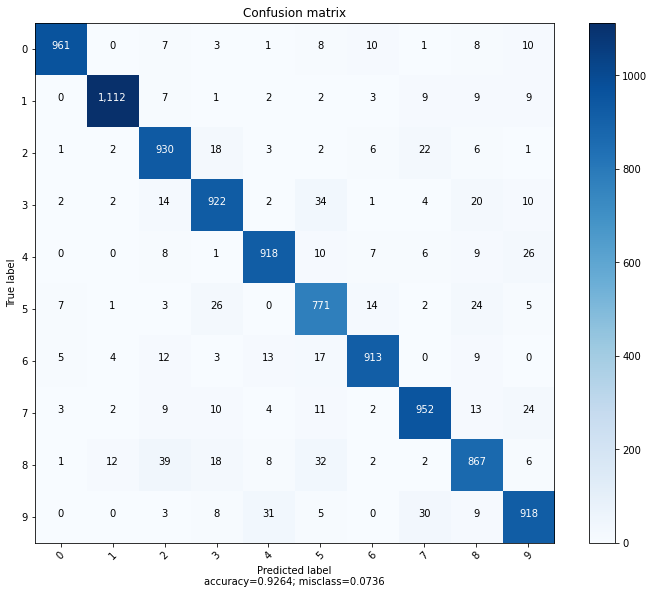

In [35]:
model_validation(ensemble_model, norm_X, x_test, Y.reshape(Y.shape[0], ), y_test)

# IV. Thực nghiệm thực tế

drawer = os.getcwd() + '\draw\main.py'

In [36]:
# Thư viện sử dụng

In [37]:
 -c config.json

SyntaxError: invalid syntax (<ipython-input-37-5a4f7950daa6>, line 1)